lasso is when the w for some features become zero so it meant as feature selection

ridge is when the w for features doesn't become zero just gets small


for linear regression no gradient is used only matrix is used

for random forest:
"n_estimators": [100, 200],
"max_depth": [None, 10, 20],
"min_samples_split": [10, 12],
"min_samples_leaf": [1, 2]

In [125]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate

In [126]:
df=pd.read_csv("feature_enginered_products.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   store             3400 non-null   object 
 1   category          3400 non-null   object 
 2   name              3400 non-null   object 
 3   product-link      3400 non-null   object 
 4   image_url         3400 non-null   object 
 5   cleaned_category  3400 non-null   object 
 6   cleaned_name      3400 non-null   object 
 7   cleaned_quantity  3400 non-null   float64
 8   cleaned_unit      3400 non-null   object 
 9   cleaned_price     3400 non-null   float64
dtypes: float64(2), object(8)
memory usage: 265.8+ KB
None


In [127]:
df["price_per_unit"]=df["cleaned_price"]/df["cleaned_quantity"]

for category, group in df.groupby("category"):
   #boxplot for price per unit by category
    #print(group["price_per_unit"].skew())
    #remove outliers
    
   q1 = group["price_per_unit"].quantile(0.25)
   q3 = group["price_per_unit"].quantile(0.75)
   iqr = q3 - q1
   lower_bound = q1 - 1.5 * iqr
   upper_bound = q3 + 1.5 * iqr
   outliers = group[(group["price_per_unit"] <= lower_bound) | (group["price_per_unit"] >= upper_bound)]
   print(f"Category: {category}, Outliers removed: {len(outliers)}")
   #select this group from the actual df
   df=df.drop(outliers.index)



Category: baby_cereals---metro, Outliers removed: 1
Category: baby_food---fateh, Outliers removed: 16
Category: baby_food---imtiaz, Outliers removed: 0
Category: baby_milk---metro, Outliers removed: 3
Category: baby_milk_and_food---jalalsons, Outliers removed: 0
Category: beverages---jalalsons, Outliers removed: 7
Category: biscuits---fateh, Outliers removed: 13
Category: biscuits_,_crisps_and_snacks---jalalsons, Outliers removed: 6
Category: biscuits_and_wafers---metro, Outliers removed: 0
Category: butter---fateh, Outliers removed: 8
Category: butter---jalalsons, Outliers removed: 1
Category: butter---metro, Outliers removed: 0
Category: carbonated_soft_drinks---imtiaz, Outliers removed: 1
Category: cheese---fateh, Outliers removed: 29
Category: cheese---metro, Outliers removed: 1
Category: chips_&_nimko---fateh, Outliers removed: 17
Category: coffee---fateh, Outliers removed: 14
Category: coffee---imtiaz, Outliers removed: 1
Category: coffee_and_whiteners---metro, Outliers removed: 

In [128]:
predicted_df=pd.DataFrame(data=[],columns=list(df.columns)+["predicted_price_elastic_net","predicted_price_linear_regression","predicted_price_random_forest"])
predicted_df.to_csv("predicted_prices.csv",index=False)

In [129]:
def elastic_net_model(X,y):
    
    print("Elastic Net Model: ")
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
    )
    
    param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99],  # Mix of L1 and L2
    "max_iter": [1000, 5000, 10000, 15000, 20000]
    }

    # Initialize Elastic Net
    elastic_net = ElasticNet(random_state=42)

    # GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(
        estimator=elastic_net,
        param_grid=param_grid,
        cv=5,  # 5-fold cross-validation
        scoring='neg_mean_squared_error',
        n_jobs=-1,  # Use all CPU cores
        verbose=1
    )

    # Fit on training data
    grid_search.fit(X_train, y_train)

    # Best parameters
    # print("\nBest Parameters:", grid_search.best_params_)
    # print("Best CV Score (MSE):", -grid_search.best_score_)
    
    best_alpha = grid_search.best_params_['alpha']
    best_l1 = grid_search.best_params_['l1_ratio']
    best_iters= grid_search.best_params_['max_iter']
    
    model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1, max_iter=best_iters, random_state=42)
    
    cv_scores = cross_validate(
    model,
    X_train,
    y_train,
    cv=2,
    scoring=['neg_mean_squared_error', 'r2'],
    return_train_score=True
    )
    
    # print("\nCross-Validation Results:")
    # print("Test MSE:", cv_scores["test_neg_mean_squared_error"].mean())
    # print("Test R2:", cv_scores["test_r2"].mean())
    # print("Train MSE:", cv_scores["train_neg_mean_squared_error"].mean())
    # print("Train R2:", cv_scores["train_r2"].mean())

    
    
    y_true=y_test
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    
    test_mse = mean_squared_error(y_true, y_pred)
    test_r2 = r2_score(y_true, y_pred)
   
    # print("\nTest Results")
    # print("MSE:", test_mse)
    # print("R2:", test_r2)
    
    train_r2,cv_r2,test_r2= cv_scores["train_r2"].mean(),cv_scores["test_r2"].mean(),test_r2
    predicted_prices=model.predict(X)
    predicted_prices=np.expm1(predicted_prices)
    
    predicted_prices=pd.DataFrame(predicted_prices, columns=["predicted_price_elastic_net"],index=X.index)
    return ([train_r2,cv_r2,test_r2],predicted_prices)

In [130]:
def linear_regression_model(X,y):
    
    print("\nLinear Regression Model: ")
     
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # --- Linear Regression Model ---
    model = LinearRegression()

    # --- Cross Validation ---
    cv_scores = cross_validate(
        model,
        X_train,
        y_train,
        cv=3,
        scoring=['neg_mean_squared_error', 'r2'],
        return_train_score=True
    )

    # print("\nCross-Validation Results:")
    # print("Test MSE:", cv_scores["test_neg_mean_squared_error"].mean())
    # print("Test R2:", cv_scores["test_r2"].mean())
    # print("Train MSE:", cv_scores["train_neg_mean_squared_error"].mean())
    # print("Train R2:", cv_scores["train_r2"].mean())

    # --- Train Final Model ---
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    # print("\nTest Results")
    # print("MSE:", test_mse)
    # print("R2:", test_r2)
    

    # --- Predict All (Exponential Back Transform) ---
    train_r2,cv_r2,test_r2= cv_scores["train_r2"].mean(),cv_scores["test_r2"].mean(),test_r2
    all_pred = model.predict(X)
    all_pred = np.expm1(all_pred)

    predicted_prices= pd.DataFrame(all_pred, columns=["predicted_price_linear_regression"], index=X.index)
    
    return ([train_r2,cv_r2,test_r2],predicted_prices)

In [131]:
def random_forest_model(X,y):
    
    print("\nRandom Forest Model: ")
    
    param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [1, 2]
    }

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    rf = RandomForestRegressor(random_state=42, n_jobs=-1)

    # --- Grid Search ---
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=3,
        scoring="neg_mean_squared_error",
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    # print("\nBest Parameters:", grid_search.best_params_)
    # print("Best CV MSE:", -grid_search.best_score_)

    best_model = grid_search.best_estimator_

    # --- Cross Validation ---
    cv_scores = cross_validate(
        best_model,
        X_train,
        y_train,
        cv=3,
        scoring=['neg_mean_squared_error', 'r2'],
        return_train_score=True
    )

    # print("\nCross-Validation Results:")
    # print("Test MSE:", cv_scores["test_neg_mean_squared_error"].mean())
    # print("Test R2:", cv_scores["test_r2"].mean())
    # print("Train MSE:", cv_scores["train_neg_mean_squared_error"].mean())
    # print("Train R2:", cv_scores["train_r2"].mean())

    # --- Test Evaluation ---
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    # print("\nTest Results")
    # print("MSE:", test_mse)
    # print("R2:", test_r2)
    # print("#" * 200)
    

    # --- Predict All (Exponential Back Transform) ---
    train_r2,cv_r2,test_r2= cv_scores["train_r2"].mean(),cv_scores["test_r2"].mean(),test_r2
    all_pred = best_model.predict(X)
    all_pred = np.expm1(all_pred)
    predicted_prices= pd.DataFrame(all_pred, columns=["predicted_price_random_forest"], index=X.index)
    return ([train_r2,cv_r2,test_r2],predicted_prices)

Category: Baby Food, Number of items: 184
Modelling for  {'Baby Food'}


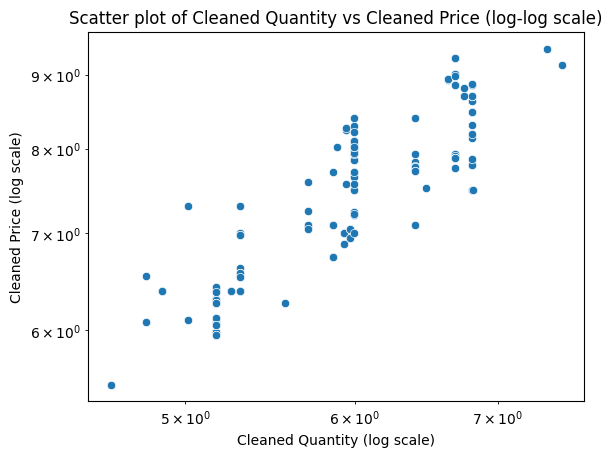

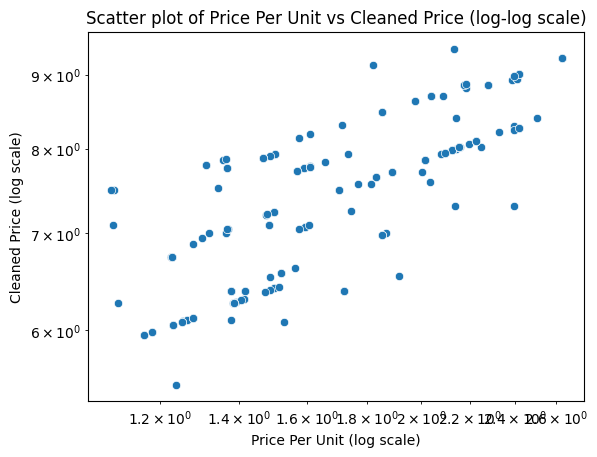

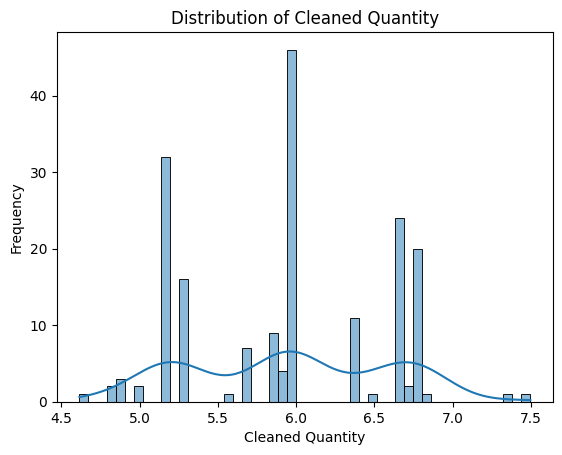

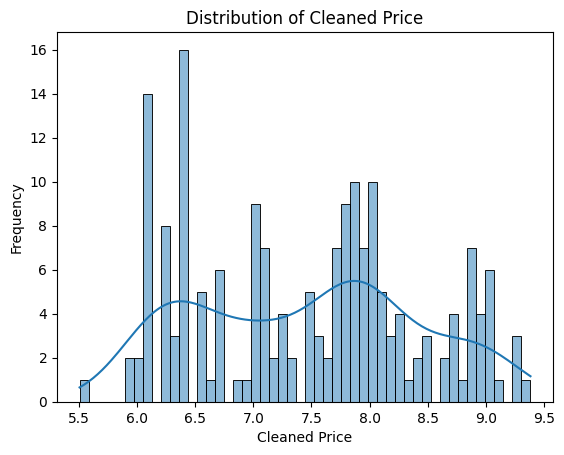

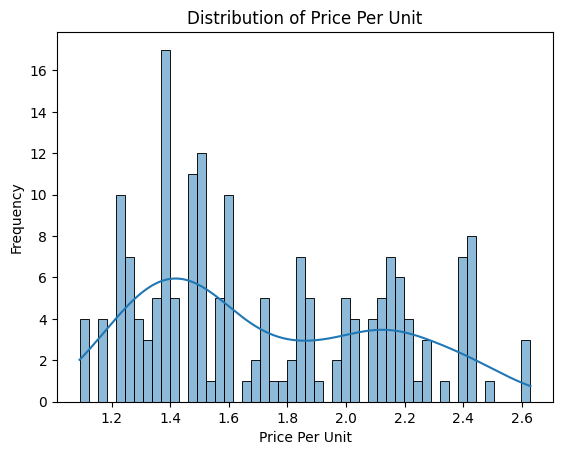

Elastic Net Model: 
Fitting 5 folds for each of 210 candidates, totalling 1050 fits

Linear Regression Model: 

Random Forest Model: 
Fitting 3 folds for each of 12 candidates, totalling 36 fits


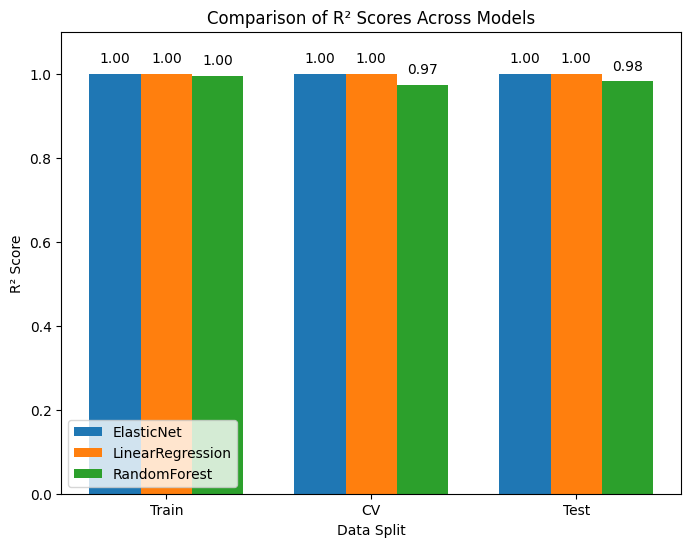

########################################################################################################################################################################################################
Category: Beverages, Number of items: 1083
Modelling for  {'Beverages'}


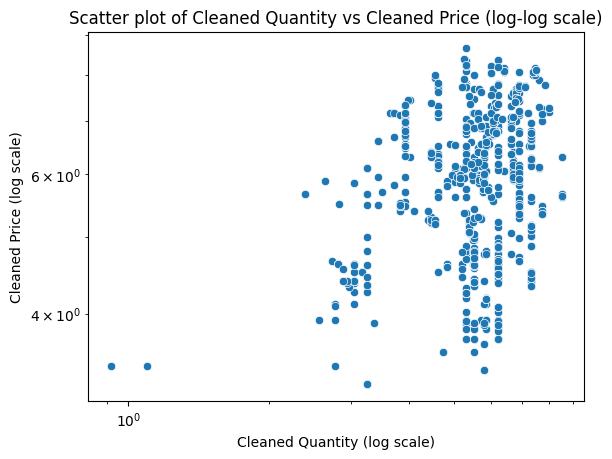

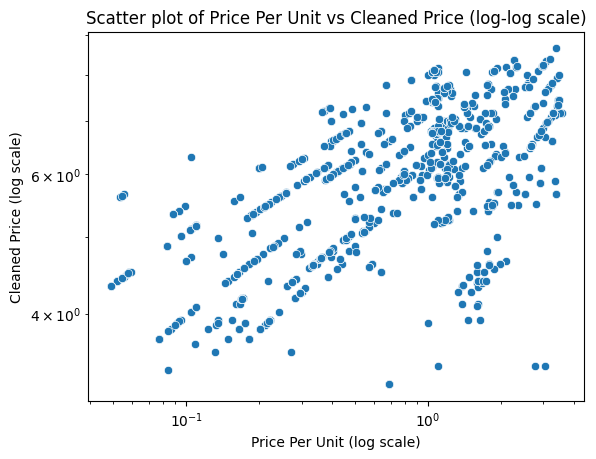

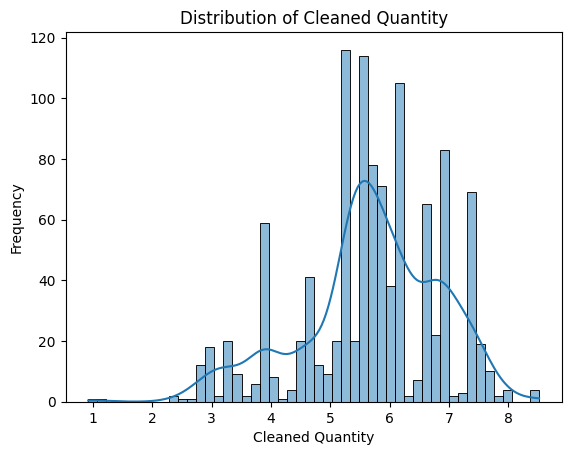

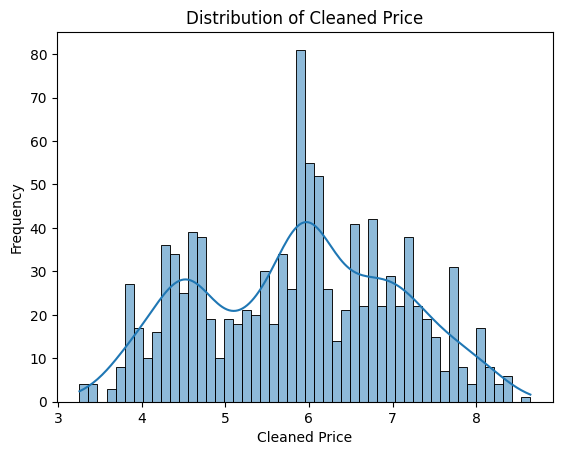

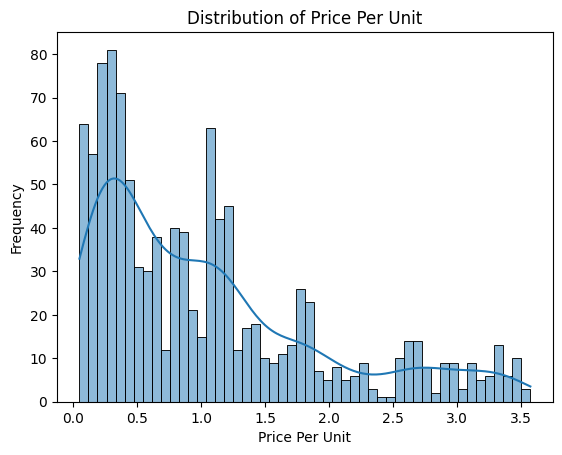

Elastic Net Model: 
Fitting 5 folds for each of 210 candidates, totalling 1050 fits

Linear Regression Model: 

Random Forest Model: 
Fitting 3 folds for each of 12 candidates, totalling 36 fits


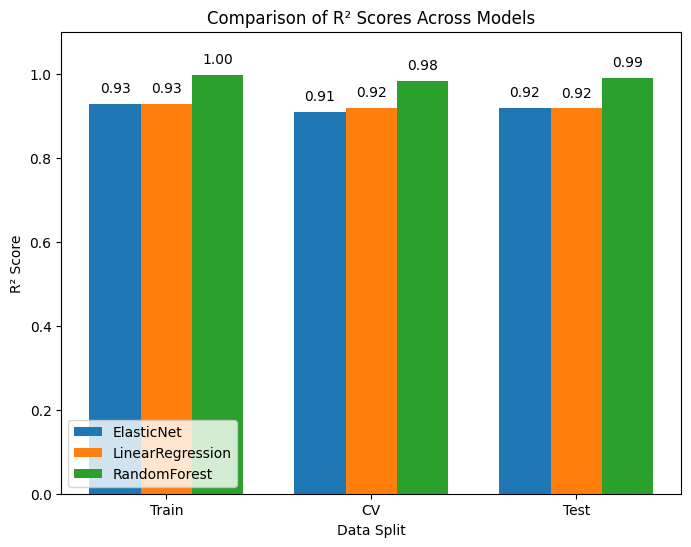

########################################################################################################################################################################################################
Category: Dairy, Number of items: 654
Modelling for  {'Dairy'}


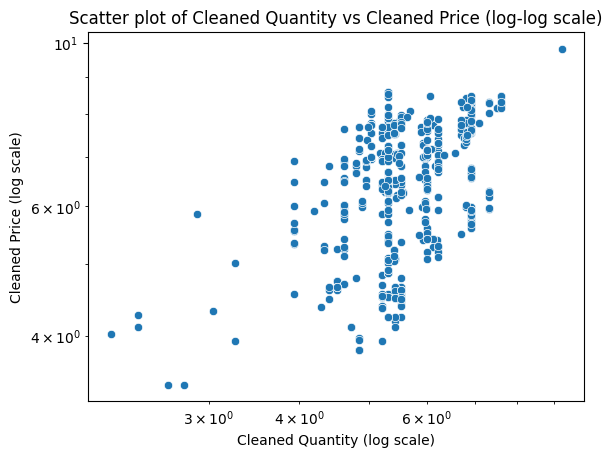

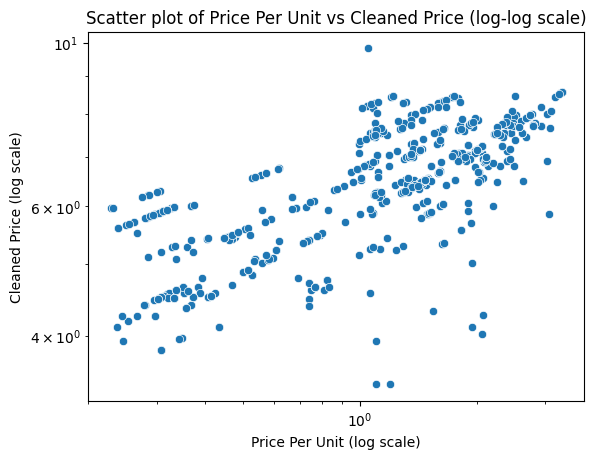

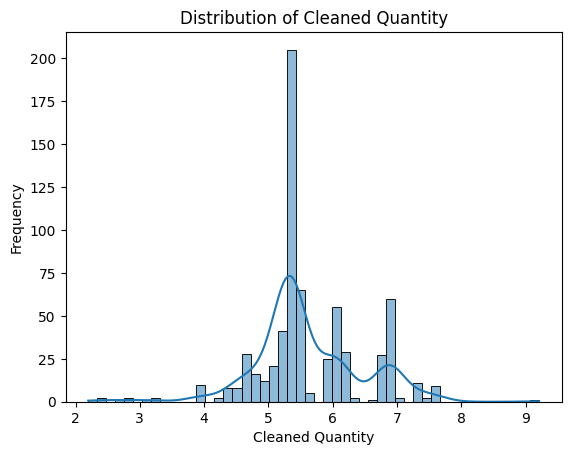

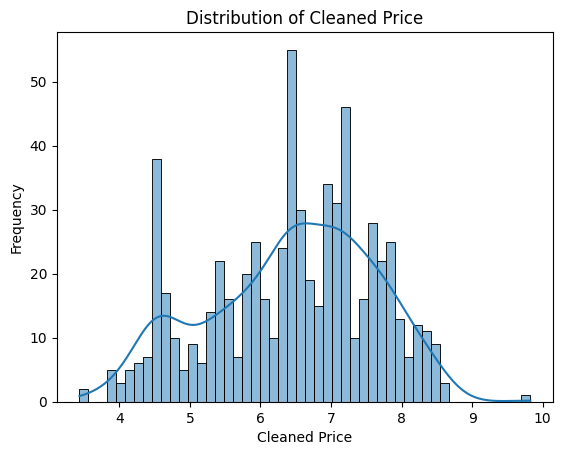

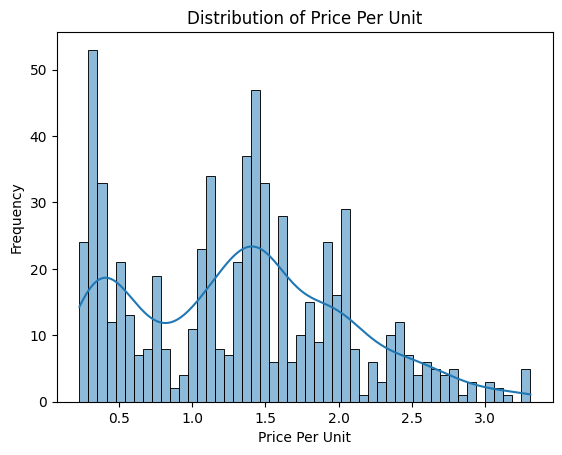

Elastic Net Model: 
Fitting 5 folds for each of 210 candidates, totalling 1050 fits

Linear Regression Model: 

Random Forest Model: 
Fitting 3 folds for each of 12 candidates, totalling 36 fits


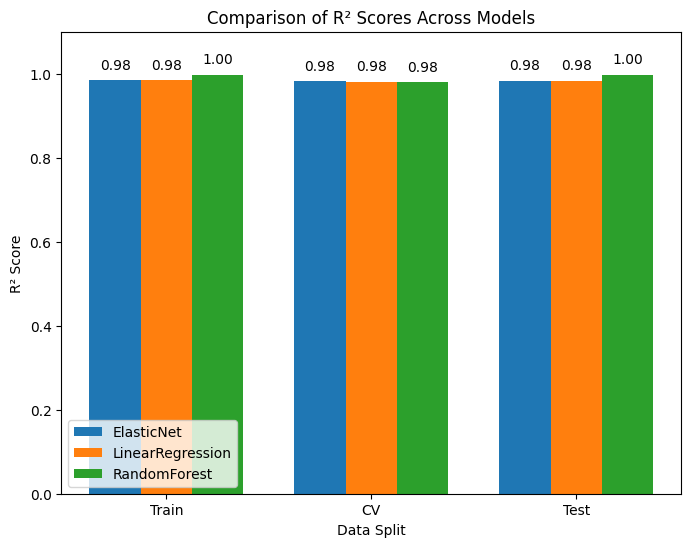

########################################################################################################################################################################################################
Category: Snacks, Number of items: 591
Modelling for  {'Snacks'}


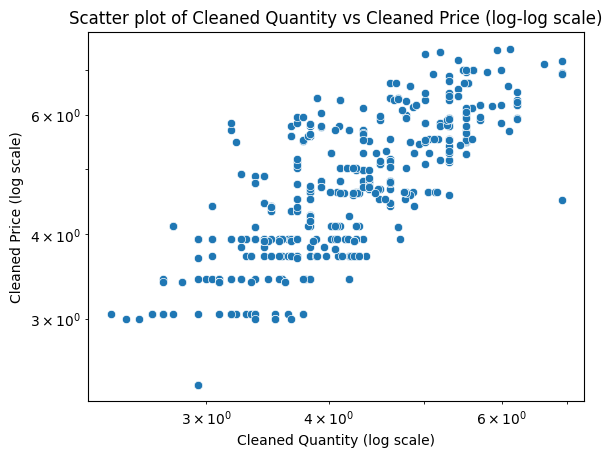

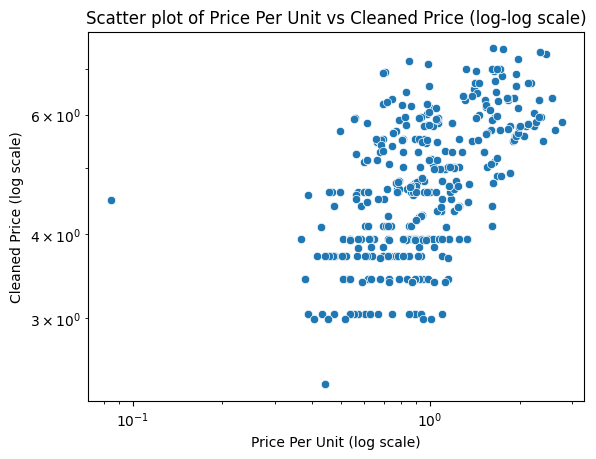

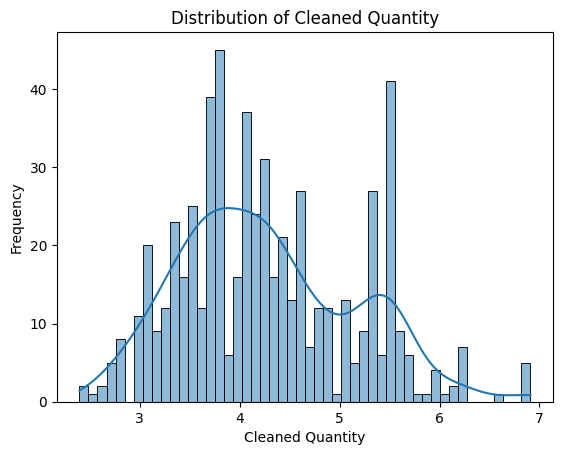

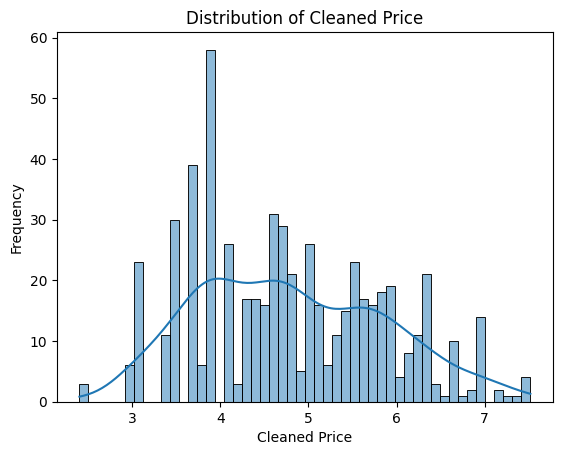

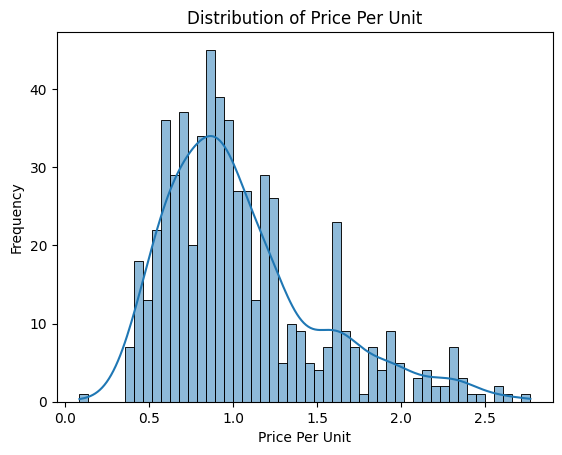

Elastic Net Model: 
Fitting 5 folds for each of 210 candidates, totalling 1050 fits

Linear Regression Model: 

Random Forest Model: 
Fitting 3 folds for each of 12 candidates, totalling 36 fits


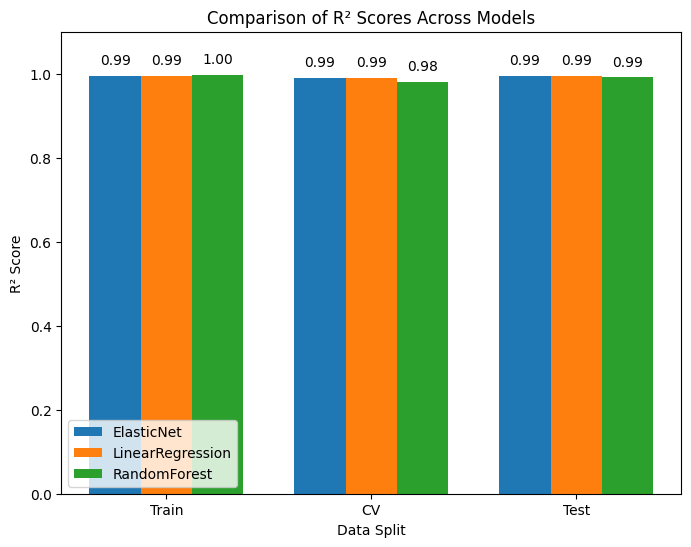

########################################################################################################################################################################################################
Category: Spices & Seasonings, Number of items: 241
Modelling for  {'Spices & Seasonings'}


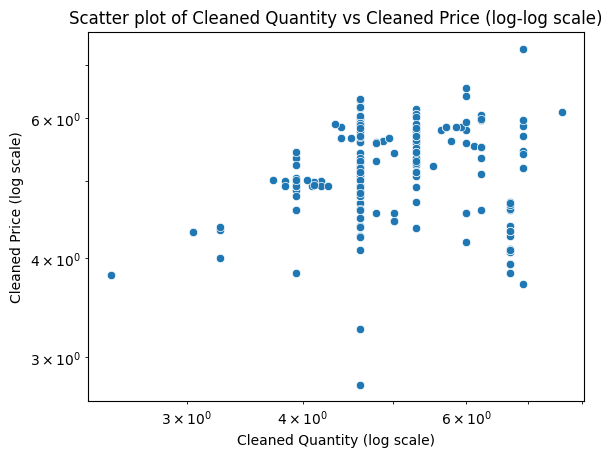

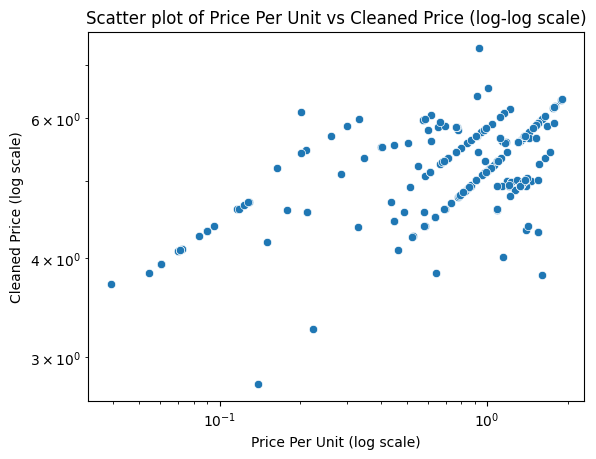

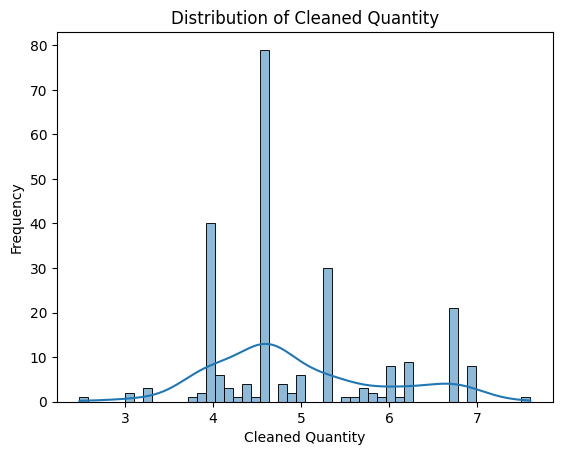

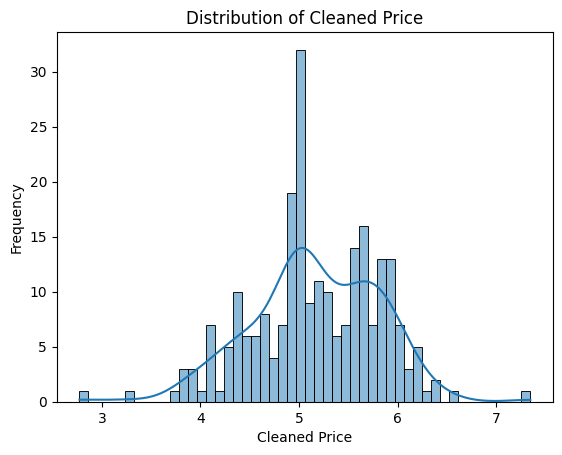

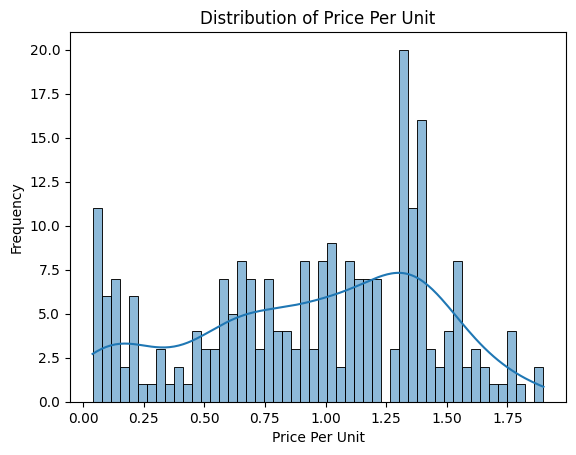

Elastic Net Model: 
Fitting 5 folds for each of 210 candidates, totalling 1050 fits

Linear Regression Model: 

Random Forest Model: 
Fitting 3 folds for each of 12 candidates, totalling 36 fits


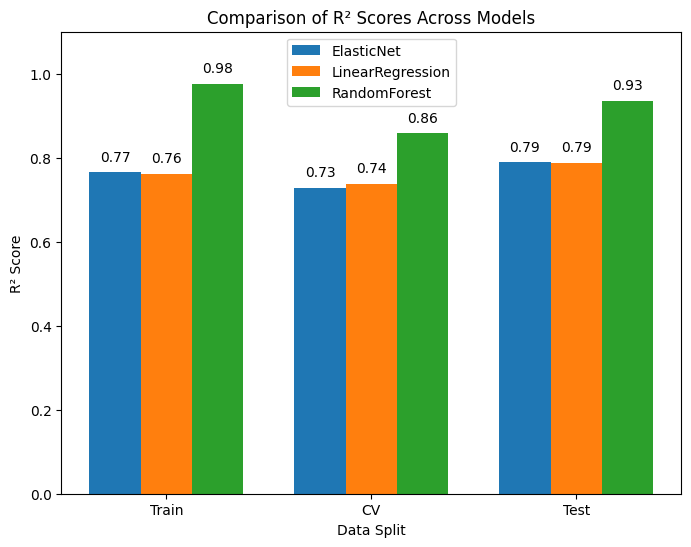

########################################################################################################################################################################################################
Category: Staples, Number of items: 299
Modelling for  {'Staples'}


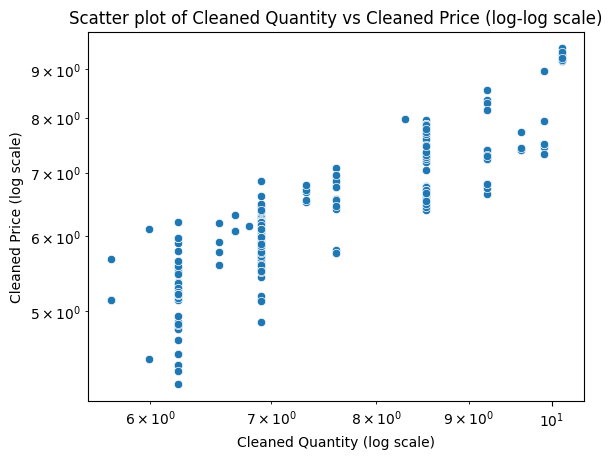

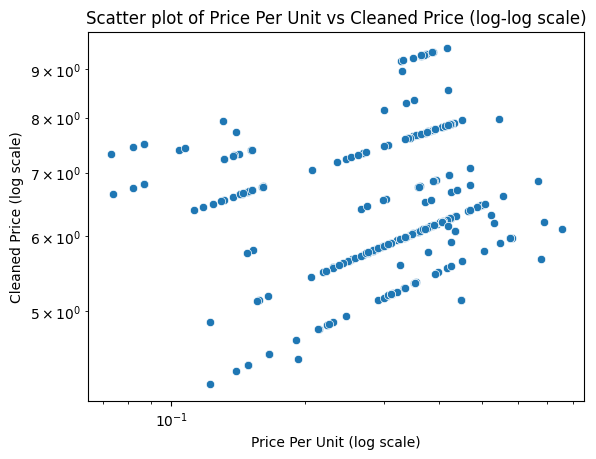

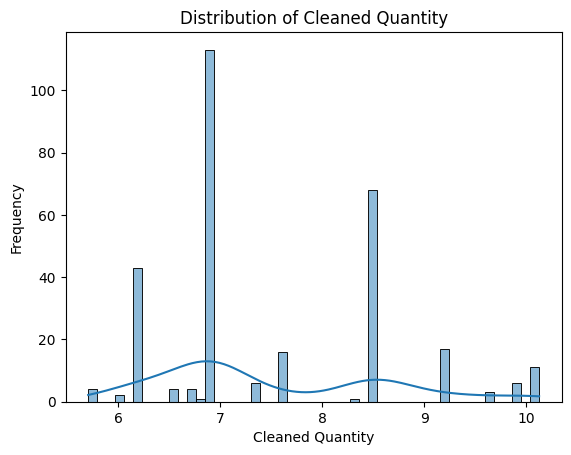

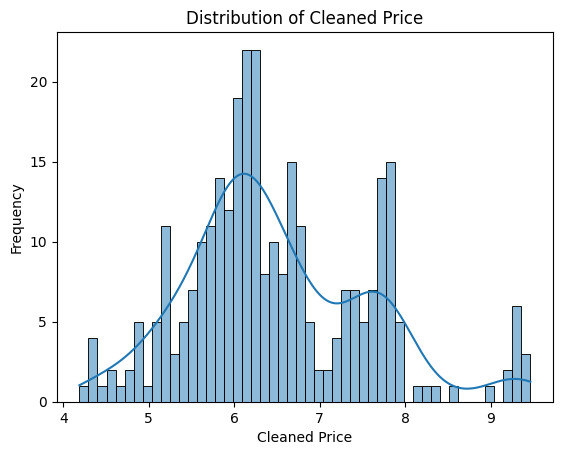

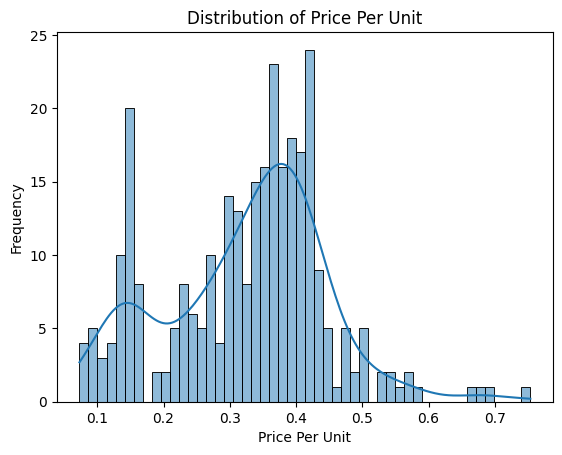

Elastic Net Model: 
Fitting 5 folds for each of 210 candidates, totalling 1050 fits

Linear Regression Model: 

Random Forest Model: 
Fitting 3 folds for each of 12 candidates, totalling 36 fits


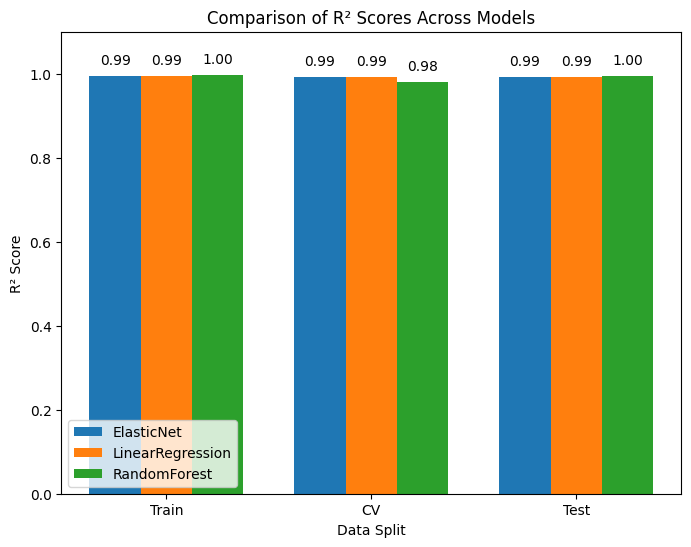

########################################################################################################################################################################################################


In [132]:
df_goruped=df.groupby("cleaned_category")

for name, group in df_goruped:
    print(f"Category: {name}, Number of items: {len(group)}") 
    print("Modelling for ",{name})
    model_df=group
    model_df=pd.get_dummies(model_df, columns=['category','store','cleaned_category',"cleaned_unit"],prefix=['category','store',"cleaned_category","cleaned_unit"], drop_first=True)
    model_df.drop([
    "name"  ,     
    "product-link" ,    
    "image_url"  ,
    "cleaned_name"
    ], axis=1, inplace=True)
    model_df["cleaned_quantity"]=np.log1p(model_df["cleaned_quantity"])
    model_df["price_per_unit"]=np.log1p(model_df["price_per_unit"])
    model_df["cleaned_price"]=np.log1p(model_df["cleaned_price"])
    
    X= model_df.drop("cleaned_price", axis=1)
    y= model_df["cleaned_price"]

    sns.scatterplot(x=model_df["cleaned_quantity"], y=model_df["cleaned_price"])
    plt.xlabel("Cleaned Quantity (log scale)")
    plt.ylabel("Cleaned Price (log scale)")
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Scatter plot of Cleaned Quantity vs Cleaned Price (log-log scale)")
    plt.show()

    sns.scatterplot(x=model_df["price_per_unit"], y=model_df["cleaned_price"])
    plt.xlabel("Price Per Unit (log scale)")
    plt.ylabel("Cleaned Price (log scale)")
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Scatter plot of Price Per Unit vs Cleaned Price (log-log scale)")
    plt.show()
    
    
    #histogram of cleaned_quantity
    sns.histplot(model_df['cleaned_quantity'], bins=50, kde=True)
    plt.title('Distribution of Cleaned Quantity')
    plt.xlabel('Cleaned Quantity')
    plt.ylabel('Frequency')
    plt.show()

    sns.histplot(model_df['cleaned_price'], bins=50, kde=True)
    plt.title('Distribution of Cleaned Price')
    plt.xlabel('Cleaned Price')
    plt.ylabel('Frequency')
    plt.show()

    sns.histplot(model_df['price_per_unit'], bins=50, kde=True)
    plt.title('Distribution of Price Per Unit')
    plt.xlabel('Price Per Unit')
    plt.ylabel('Frequency')
    plt.show()
    
    
    tct_r2_elastic,predicted_prices_elastic_net=elastic_net_model(X,y)
    tct_r2_linear,predicted_prices_linear_regression=linear_regression_model(X,y)
    tct_r2_forest,predicted_prices_random_forest=random_forest_model(X,y)
   
    # Combine into a matrix: rows = R² types, columns = models
    r2_scores = np.array([tct_r2_elastic, tct_r2_linear, tct_r2_forest]).T
    # shape now: (3 R² types, 3 models)

    r2_types = ['Train', 'CV', 'Test']
    models = ['ElasticNet', 'LinearRegression', 'RandomForest']

    x = np.arange(len(r2_types))  # positions for Train, CV, Test
    width = 0.25  # width of each bar

    fig, ax = plt.subplots(figsize=(8,6))

    # Plot bars for each model
    for i in range(len(models)):
        ax.bar(x + (i-1)*width, r2_scores[:, i], width, label=models[i])

    # Labels, title, legend
    ax.set_ylabel('R² Score')
    ax.set_xlabel('Data Split')
    ax.set_title('Comparison of R² Scores Across Models')
    ax.set_xticks(x)
    ax.set_xticklabels(r2_types)
    ax.set_ylim(0, 1.1)  # increase ylim so bars and text don't hit top
    ax.legend()

    # Annotate values on top of bars with small offset
    for i in range(len(r2_types)):
        for j in range(len(models)):
            ax.text(x[i] + (j-1)*width, r2_scores[i,j]+0.02,  # offset by 0.02
                    f'{r2_scores[i,j]:.2f}', ha='center', va='bottom', fontsize=10)

    plt.show()

   
    predicted_df = pd.concat(
        [group,predicted_prices_elastic_net,predicted_prices_linear_regression,predicted_prices_random_forest],
        axis=1
    )

    predicted_df.to_csv(
        "predicted_prices.csv",
        mode="a",
        header=False,
        index=False
    )

    print("#" * 200)
    